## Import modules

In [ ]:
import os
from __future__ import division
import math
import sklearn
from sklearn.metrics import classification_report
from sklearn import preprocessing
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML
import seaborn as sns
import datetime

%matplotlib inline


## Data description:


In [ ]:
df = pd.read_csv('SalesbyHour.csv')
df.head()

In [ ]:
df.sample(n=5)

In [ ]:
df.describe()

# Revise index

In [ ]:
df['Date']=pd.to_datetime(df['DateStringYYYYMMDD'].astype(str), format='%Y%m%d')
# del df['DateStringYYYYMMDD']
df = df.sort_values('Date',ascending=True)

In [ ]:
df['Timestamp'] = df['Date']+df.Hour.apply(lambda x: pd.Timedelta(hours=x))
df = df.sort_values('Timestamp',ascending=True)

In [ ]:
# df = df.sort_index(ascending=True)
df.head()

In [ ]:
del df['DateStringYYYYMMDD']

## Sales by store
### Time series plots
Note: only run if you want to see each graph

In [ ]:
for ID in range(len(df['Store_ID'].unique())):
    plt.figure(figsize=(40,10))
    plt.rc('font',size=30)
    plt.title("Store {}".format(list(df.set_index('Timestamp').groupby('Store_ID'))[ID][0]))
    plt.xlabel('Time')
    plt.ylabel('Sales Revenue')
    plt.plot(list(df.set_index('Timestamp').groupby('Store_ID'))[ID][1]['SalesRevenue']) 

### Sales Revenue Distribution plots:
Note: Only run if you want to see each graph

In [ ]:
for ID in range(len(df['Store_ID'].unique())):
    plt.figure()
    plt.rc('font',size=10)

    tempdf = list(df.set_index('Timestamp').groupby('Store_ID'))[ID][1]['SalesRevenue']

    plt.title("Store {}".format(list(df.set_index('Timestamp').groupby('Store_ID'))[ID][0]))
    sns.distplot(tempdf,
                 label="std: "+str(np.std(tempdf))+"\n Mean: "+str(np.mean(tempdf)))
    plt.legend()

In [ ]:
df.groupby('Store_ID')['SalesRevenue'].describe()

# One-hot encode
* Fiscal_Qtr
* Fiscal_dayofWk
* Daypart
* HourlyWeather
* Store_ID

In [ ]:
#One-hot encoding

dummies = []

dummies.append(pd.get_dummies(df['Fiscal_dayofWk'],prefix="Day_"))
dummies.append(pd.get_dummies(df['Fiscal_Qtr'],prefix="Qtr_"))
dummies.append(pd.get_dummies(df['Store_ID'],prefix="Store_"))

In [ ]:
dummies.append(pd.get_dummies(df['Daypart']))
dummies.append(pd.get_dummies(df['HourlyWeather']))

In [ ]:
full_df = df.join(dummies)

### Total weekly sales

In [ ]:
plt.figure(dpi=80)
full_df.set_index('Timestamp').resample('W').sum()['SalesRevenue'].plot()

In [ ]:
full_df.info()

# Verify data consistency

### Plot graphs to see whether they resemble what data should actually look like
Note: only plot if you want to see every graph

In [ ]:
for a, b in full_df.groupby('Store_ID'):
    plt.figure()
    b.set_index('Timestamp')['SalesRevenue'][:100].plot()

In [ ]:
full_df.isnull().sum()

# Normalize Data

### Remove outliers

In [ ]:
from scipy import stats

In [ ]:
full_df['SalesRevenue'].describe()

In [ ]:
sales = full_df['SalesRevenue']
sns.distplot(sales)

OLS and other regression models perform poorly when there are extreme outliers. Certain stores, notably store 17 and 20 have some sales days that are so extreme, they are 10 standard deviations away from the mean. These absurdly high sales could have been from employees misreporting sales, or they might have actually happened. Either way, nothing about the information in the dataset is useful in actually predicting them

In [ ]:
full_df[(full_df['SalesRevenue']>10*np.std(sales)+np.mean(sales))].groupby('Store_ID').describe()

In [ ]:
full_df = full_df[(full_df['SalesRevenue']<10*np.std(sales)+np.mean(sales))]

Additionally, many reports show negative revenues. Either Sales Revenue is a misnomer, or employees are misreporting sales. If this were traditional retail, negative revenue could potentially make sense if customers were making large returns, but in fast food, this is unlikely. So, these points will be removed from the dataset.

In [ ]:
full_df[(full_df['SalesRevenue']<0)].groupby('Store_ID').describe()

Remove negative values

In [ ]:
full_df = full_df[(full_df['SalesRevenue']>=0)]

In [ ]:
full_df.groupby('Store_ID')['SalesRevenue'].describe()

# Rolling Average
Rolling average helps us measure the "momentum" of sales in a store. Good way to account for seasonality.

In [ ]:
lag = pd.rolling_mean(full_df.set_index('Date')['SalesRevenue'].resample("1D"),1)
lag = pd.DataFrame(lag)
lag=lag.reset_index()
lag.columns=['Date','Rolling_mean']

#Last value is used as the rolling average in the test set
last_rm = lag['Rolling_mean'].tail(1).copy()

#Each value is shifted to the proceeding date so that the classifier cannot see into the future
lag['Rolling_mean'] = lag['Rolling_mean'].shift(1)
lag.head()

In [ ]:
plt.figure(dpi = 100)
plt.plot(full_df.merge(lag,on='Date')['SalesRevenue'],label="Sales Revenue")
plt.plot(full_df.merge(lag,on='Date')['Rolling_mean'],label= 'Rolling Mean')
plt.legend()

# pd.DataFrame(full_df.index.join(lag.index))


In [ ]:
lagged_df = full_df.merge(lag,on='Date')

### Rolling average per store

In [ ]:
#dictionary of daily average by store ID
daily = {}
for i in list(lagged_df.groupby('Store_ID')):
    daily[i[0]]=i[1]

In [ ]:
store_IDs = lagged_df['Store_ID'].unique()
store_final_rms = {}

#Test set values of rolling mean for final day
for store in store_IDs:
    rm = pd.rolling_mean(daily[store].set_index('Date')['SalesRevenue'].resample('1D'),1)
    rm = pd.DataFrame(rm)
    rm =  rm.reset_index()
    rm.columns=['Date',"Store RM "+str(store)]
    
    #Save last day rolling means so that they can be used in test set
    store_final_rms[store] = rm['Store RM '+str(store)].tail(1).copy(True)
    
    rm = lagged_df.merge(rm,on='Date',how='left')

    lagged_df = rm.fillna(method="bfill")
    # plt.plot(full_df.merge(rm,on='Date')['SalesRevenue'])
    # plt.plot(full_df.merge(rm,on='Date')['rm_1'])

In [ ]:
# Shift individual rolling means and fillna
for store in store_IDs:
    #Shift so that future values aren't read
    lagged_df["Store RM "+str(store)] = rm["Store RM "+str(store)].shift(1)

lagged_df = rm.fillna(method="bfill")


Turn timestamp to proper type

In [ ]:
lagged_df['Timestamp']=pd.to_numeric(lagged_df['Timestamp'])

In [ ]:
# Check if columns align well
lagged_df.head()

### Display each store's average sales over time
Note: only run if you want to see each graph

In [ ]:
for store in lagged_df.iloc[:,50:].columns:
    plt.figure()
    plt.title("Store {}".format(store))
    plt.plot(lagged_df[store])
    plt.legend()

### Test set
"Using only the attached data set, identify the top predictors of hourly sales and predict total sales revenue for all 14 stores on 2017-07-15 during hour 12, assuming a clear day and average temperature of 86 degrees."

In [ ]:
t = lagged_df.tail(1).copy()
# pd.options.display.max_columns = None

t['Fiscal_dayofWk']=6
t['Hour']=12
t['AvgHourlyTemp'] = 86
t['Day__5']=0
t['Day__6']=1
t['Store__32']=0
t['Late Night']=0
t['Late Night']=0
t['Lunch']=1
t['clear-day']=1
t['Rolling_mean'] = last_rm.iloc[0]
t['Timestamp'] = pd.datetime(2017,7,15) + pd.Timedelta(int(t['Hour']),unit='h')
t['Timestamp'] = pd.to_numeric(t['Timestamp'])

t = t.drop(['Daypart','HourlyWeather','Store_ID','Date'],axis=1)

In [ ]:
for ID in store_IDs:
    t['Store RM '+str(ID)] = store_final_rms[ID].iloc[0]

In [ ]:
# Store specific values
test_set = {}
for ID in store_IDs:
    test_set[ID] = t.copy()
    test_set[ID]['Store__'+str(ID)] = 1

## Minmax scaling
Why normalize?
"Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. For example, the majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

Another reason why feature scaling is applied is that gradient descent converges much faster with feature scaling than without it"
https://en.wikipedia.org/wiki/Feature_scaling

In [ ]:
X = lagged_df.drop(['Daypart','HourlyWeather','Store_ID','Date'],axis=1)

In [ ]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = pd.DataFrame(min_max_scaler.fit_transform(X), columns=X.columns, index=X.index)

In [ ]:
testdf = pd.DataFrame({'a': [1,2,3,4,5],'b':[1,231231,41,3,2]})
mms = sklearn.preprocessing.MinMaxScaler()
mms.fit_transform(testdf)

In [ ]:
testdf

In [ ]:
test2 = pd.DataFrame({'a': [5],'b':[1]})
mms.transform(testdf)

Scale test set

In [ ]:
# Scale each test set designed specifically for each store
for store in store_IDs:
    test_set[store] = pd.DataFrame(min_max_scaler.transform(test_set[store]) ,columns=test_set[store].columns)

In [ ]:
test_set[20]

In [ ]:
X = pd.DataFrame(np_scaled).drop('SalesRevenue',axis=1)
y= pd.DataFrame(np_scaled)['SalesRevenue']
X.head()

# Model Selection

For testing over the entire sampleset:

In [ ]:
from sklearn.model_selection import train_test_split

Rolling window cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
tscv_list=[]

for train_index, test_index in tscv.split(X):
    tscv_list.append([train_index,test_index])
    

In [ ]:
def RollingWindowCV(model, X=X, y=y, tscv_list=tscv_list, graphs=False):
    """
    model: Trained model
    X: features
    y: target
    tscv_list: time series cross validation list
    """
    predictions = []
    split_num=1

    for test in tscv_list:
        X_train = X.iloc[test[0],]
        y_train = y.iloc[test[0],]
        X_test = X.iloc[test[1],]
        y_test = y.iloc[test[1],]

        #fit
        model.fit(X_train,y_train)

        #score
        score = model.score(X_test,y_test)
        print("Split {} R squared: {}".format(split_num,str(round(score,4))))
        
        #Graph
        if graphs:
            plt.figure(figsize=(9,4))
            plt.rc('font', size=13)  
            plt.title('100 Sample Forecast Split {} \n R squared: {}'.format(split_num, str(round(score,4))))
            plt.xlabel('Time')
            plt.ylabel('SalesRevenue')
            plt.plot(y_test.reset_index(drop=True)[:100],label="Ground Truth")
            plt.plot(model.predict(X_test.reset_index(drop=True)[:100]),label="Predicted Values")
            plt.legend()
        
        split_num+=1


## OLS Regression

In [ ]:
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [ ]:
reg.fit(X,y)

In [ ]:
plt.figure()
plt.rc('font', size=20)  
plt.title('100 Sample Fitness')
plt.xlabel('Time')
plt.ylabel('SalesRevenue')
plt.plot(y[:100])
plt.plot(reg.predict(X)[:100])


In [ ]:
reg.score(X,y)

### Test

In [ ]:
RollingWindowCV(reg,graphs=False)

## Random Forest Regression

In [ ]:
from sklearn import ensemble
RFR = ensemble.RandomForestRegressor()

In [ ]:
RFR.fit(X,y)

In [ ]:
plt.figure()
plt.rc('font', size=20)  
plt.title('100 Sample Fitness')
plt.xlabel('Time')
plt.ylabel('SalesRevenue')
plt.plot(y[:100])
plt.plot(RFR.predict(X)[:100])


In [ ]:
RFR.score(X,y)

### Test

In [ ]:
RollingWindowCV(RFR,graphs=False)

## Ridge Regression

In [ ]:
ridge = linear_model.Ridge(alpha=0.5)

In [ ]:
ridge.fit(X,y)

In [ ]:
plt.figure()
plt.rc('font', size=20)  
plt.title('100 Sample Fitness')
plt.xlabel('Time')
plt.ylabel('SalesRevenue')
plt.plot(y[:100])
plt.plot(ridge.predict(X)[:100])

In [ ]:
ridge.score(X,y)

### Test

In [ ]:
RollingWindowCV(ridge,graphs=False)

## Lasso Regression

In [ ]:
lasso = linear_model.LassoCV()
lasso.fit(X,y)

In [ ]:
lasso.score(X,y)

In [ ]:
plt.figure()
plt.rc('font', size=20)  
plt.title('100 Sample Fitness')
plt.xlabel('Time')
plt.ylabel('SalesRevenue')
plt.plot(y[:100])
plt.plot(lasso.predict(X[:100]))

### Test

In [ ]:
RollingWindowCV(lasso, graphs=False)

# Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
GBR = GradientBoostingRegressor()
GBR.fit(X,y)

In [ ]:
GBR.score(X,y)

In [ ]:
plt.figure()
plt.rc('font', size=20)  
plt.title('100 Sample Fitness')
plt.xlabel('Time')
plt.ylabel('SalesRevenue')
plt.plot(y[:100])
plt.plot(GBR.predict(X)[:100])

In [ ]:
RollingWindowCV(GBR,graphs=False)

# Model Validation

## Tree Based Models

List top features in tree based regressors

In [ ]:
def TreeFeatureEvaluation(model, X=X):
    features = zip(X.columns, model.feature_importances_)
    features = sorted(features, key = lambda x:x[1], reverse=True)
    for feat in features:
        print(feat)
    return features

Create diagram visualizing coefficients

In [ ]:
# Function used to plot the feature importances as a pie chart
def TreeFeatureChart(x, top_N_features=7):
    labels = [x[n][0] for n in range(len(x))][:top_N_features]
    labels.append('Other')
    values =[x[n][1] for n in range(len(x))][:top_N_features]
    values.append(1-sum(values))
    plt.rc('font',size=15)

    fig1, ax1 = plt.subplots()
    ax1.pie(values, labels=labels, autopct=None,
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.legend(labels, loc='best', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)
    plt.title("Features by importance")
    plt.show()

### Random Forest

In [ ]:
RFR_feats = TreeFeatureEvaluation(RFR)

In [ ]:
TreeFeatureChart(RFR_feats)

### Gradient Boosting Regressor

In [ ]:
GBR_feats = TreeFeatureEvaluation(GBR)

In [ ]:
TreeFeatureChart(GBR_feats)

## Regression based models

Coefficient list

In [ ]:
def RegFeatureEvaluation(coef, labels):
    """
    coef: Coeficients
    labels: Label names
    """
    features = zip(labels, coef)
    features = sorted(features, key = lambda x:x[1], reverse=True)
    for feat in features:
        print(feat)

Coefficient visualization

In [ ]:
def RegFeatureChart(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))

    split_index = 0
    for i in range(len(imp)):
        if imp[i] >=0:
            split=i
            break
    split_index+=1
    
    
    # Positive features
    plt.figure(dpi=100)
    plt.rc('font',size=10)
    plt.barh(range(len(names[:i])), imp[:i], align='center')
    plt.yticks(range(len(names[:i])), names[:i])
    plt.show()
    
    # Negative Features
    plt.figure(dpi=90)
    plt.barh(range(len(names[i-1:])), imp[i-1:], align='center')
    plt.yticks(range(len(names[i-1:])), names[i-1:])
    plt.show()

### OLS

In [ ]:
RegFeatureEvaluation(reg.coef_,X.columns)

In [ ]:
RegFeatureChart(reg.coef_,X.columns)

### Ridge

In [ ]:
RegFeatureEvaluation(ridge.coef_,X.columns)

In [ ]:
RegFeatureChart(ridge.coef_,X.columns)

### Lasso

In [ ]:
RegFeatureEvaluation(lasso.coef_,X.columns)

In [ ]:
RegFeatureChart(lasso.coef_,X.columns)

# Forecast

In [ ]:
def InvertPrediction(item, model, scaler):
    """
    Given a normalized line item, the model, and the scaler, returns the original value
    """
    temp = item.copy()
    prediction = model.predict(item.drop('SalesRevenue',axis=1))
    temp['SalesRevenue'] = prediction
    
    return pd.DataFrame(scaler.inverse_transform(temp),columns=temp.columns)['SalesRevenue'].tail(1)
    


In [ ]:
for ID in test_set:
    item = test_set[ID].copy()
    print("Store number", ID)
    
    print("OLS: {}".format(InvertPrediction(item,ridge,min_max_scaler)))
    print("Ridge: {}".format(InvertPrediction(item,ridge,min_max_scaler)))
    print("Lasso: {}".format(InvertPrediction(item,lasso,min_max_scaler)))
    print("Random Forest: {}".format(InvertPrediction(item,RFR,min_max_scaler)))
    print("GB Regresion: {}".format(InvertPrediction(item,GBR,min_max_scaler)))
    print(20*"-")
    


# Creating a model for each store individually
Unfortunately, the forecasts are still very unreliable. So, each store will be assessed individually.

### Min max scale each store's data

In [ ]:
individuals = dict()
stores = list(lagged_df.groupby('Store_ID'))

for ID in range(len(store_IDs)):
    store = stores[ID][1].drop(['Daypart','HourlyWeather','Store_ID','Date'],axis=1).copy()
    store['Timestamp'] = pd.to_numeric(store['Timestamp'])
    individuals[stores[ID][0]]= pd.DataFrame(data = min_max_scaler.transform(store),columns=store.columns)
    individuals[stores[ID][0]]= individuals[stores[ID][0]].append(test_set[stores[ID][0]])

In [ ]:
individuals[2]

## Classification reports for each model

In [ ]:
def ModelReport(Store_ID, model, graphs=False):
    '''
    Given a unique store ID and model, creates an R^2 report
    Store_ID: Store's unique ID
    Model: name of model to train 
    '''
    
    X = individuals[Store_ID].drop('SalesRevenue',axis=1)
    X = X.reset_index(drop=True)
    y = individuals[Store_ID]['SalesRevenue']
    y = y.reset_index(drop=True)
    
    tscv = TimeSeriesSplit(n_splits=10)
    tscv_list=[]

    for train_index, test_index in tscv.split(X):
        tscv_list.append([train_index,test_index])
    display('Results for Store {}'.format(Store_ID))
    RollingWindowCV(model=model,X=X,y=y,tscv_list=tscv_list,graphs=graphs)
    


### OLS

In [ ]:
LRG = linear_model.LinearRegression()
for ID in store_IDs:
    ModelReport(Store_ID=ID, model=LRG, graphs=False)

In [ ]:
pd.options.display.max_columns = None


for ID in store_IDs:
    LRG.fit(individuals[ID].drop('SalesRevenue',axis=1),individuals[ID]['SalesRevenue'])
    plt.figure(dpi=100)
    plt.title("Store ID {}".format(ID))
#     plt.plot(individuals[ID].reset_index()['SalesRevenue'].tail(200))
    plt.plot(LRG.predict(individuals[ID].drop('SalesRevenue',axis=1)))

# Test set

In [ ]:
for ID in store_IDs:
    LRG = linear_model.LinearRegression()
    LRG.fit(X = individuals[ID].drop('SalesRevenue',axis=1),
            y = individuals[ID]['SalesRevenue'])
    prediction = LRG.predict(test_set[ID].drop('SalesRevenue',axis=1))[-1:]
#     display(prediction)
    test_set[ID]['SalesRevenue']=prediction
    display("Store {} Predicted Sales: ".format(ID))
    display(pd.DataFrame(min_max_scaler.inverse_transform(test_set[ID]),
                         columns=test_set[ID].columns)['SalesRevenue'])

In [ ]:
InvertPrediction(individuals[ID].tail(1),LRG,min_max_scaler)

## Predictions

In [ ]:
for ID in store_IDs:
    item = test_set[ID]
    print("Store number", ID)  
    LRG.fit(individuals[ID].drop('SalesRevenue',axis=1),individuals[ID]['SalesRevenue'])
#     print("OLS: {}".format(InvertPrediction(item,LRG,min_max_scaler)))
#     print(InvertPrediction(item,LRG,min_max_scaler))
    display(pd.DataFrame(min_max_scaler.inverse_transform(item),columns=item.columns))
    print(20*"-")
    display(item)

## Lasso

In [ ]:
lasso = linear_model.LassoCV()

for ID in store_IDs:
    ModelReport(Store_ID=ID, model=lasso, graphs=False)

Note: only run if you want to see each graph

In [ ]:
for ID in store_IDs:
    lasso.fit(individuals[ID].drop('SalesRevenue',axis=1),individuals[ID]['SalesRevenue'])
    plt.figure()
    plt.title("Store ID {}".format(ID))
    plt.plot(individuals[ID].reset_index()['SalesRevenue'][:200])
    plt.plot(lasso.predict(individuals[ID].drop('SalesRevenue',axis=1)[:200]))

## Predictions

In [ ]:
for ID in store_IDs:
    lasso = linear_model.LassoCV()
    lasso.fit(X = individuals[ID].drop('SalesRevenue',axis=1),
            y = individuals[ID]['SalesRevenue'])
    prediction = lasso.predict(test_set[ID].drop('SalesRevenue',axis=1))[-1:]
#     display(prediction)
    test_set[ID]['SalesRevenue']=prediction
    display("Store {} Predicted Sales: ".format(ID))
    display(pd.DataFrame(min_max_scaler.inverse_transform(test_set[ID]),
                         columns=test_set[ID].columns)['SalesRevenue'])

## Ridge 

In [ ]:
ridge = linear_model.Ridge()
for ID in store_IDs:
    ModelReport(Store_ID=ID, model=ridge,graphs=False)

Note: only run if you want to see each graph

In [ ]:
for ID in store_IDs:
    ridge.fit(individuals[ID].drop('SalesRevenue',axis=1),individuals[ID]['SalesRevenue'])
    plt.figure()
    plt.title("Store ID {}".format(ID))
    plt.plot(individuals[ID].reset_index()['SalesRevenue'][:200])
    plt.plot(ridge.predict(individuals[ID].drop('SalesRevenue',axis=1)[:200]))

## Predictions

In [ ]:
for ID in store_IDs:
    ridge = linear_model.Ridge()
    ridge.fit(X = individuals[ID].drop('SalesRevenue',axis=1),
            y = individuals[ID]['SalesRevenue'])
    prediction = ridge.predict(test_set[ID].drop('SalesRevenue',axis=1))[-1:]
#     display(prediction)
    test_set[ID]['SalesRevenue']=prediction
    display("Store {} Predicted Sales: ".format(ID))
    display(pd.DataFrame(min_max_scaler.inverse_transform(test_set[ID]),
                         columns=test_set[ID].columns)['SalesRevenue'])

### Random forest

In [ ]:
RFR = ensemble.RandomForestRegressor()

for ID in store_IDs:
    ModelReport(Store_ID=ID, model=RFR, graphs=False)

Note: only run if you want to see each graph

In [ ]:
for ID in store_IDs:
    RFR.fit(individuals[ID].drop('SalesRevenue',axis=1),individuals[ID]['SalesRevenue'])
    plt.figure(figsize=(25,5))
    plt.title("Store ID {}".format(ID))
    plt.plot(individuals[ID].reset_index()['SalesRevenue'][:200])
    plt.plot(RFR.predict(individuals[ID].drop('SalesRevenue',axis=1)[:200]))

## Predictions

In [154]:
for ID in store_IDs:
    RFR = ensemble.RandomForestRegressor()
    RFR.fit(X = individuals[ID].drop('SalesRevenue',axis=1),
            y = individuals[ID]['SalesRevenue'])
    prediction = RFR.predict(test_set[ID].drop('SalesRevenue',axis=1))[-1:]
#     display(prediction)
    test_set[ID]['SalesRevenue']=prediction
    display("Store {} Predicted Sales: ".format(ID))
    display(pd.DataFrame(min_max_scaler.inverse_transform(test_set[ID]),
                         columns=test_set[ID].columns)['SalesRevenue'])

### Gradient Boosting Regressor

In [155]:
for ID in store_IDs:
    ModelReport(Store_ID=ID, model=GBR, graphs=False)

Split 7 R squared: 0.6878
Split 8 R squared: 0.5483
Split 9 R squared: 0.6937
Split 10 R squared: 0.7025


'Results for Store 11'

Split 1 R squared: 0.0243
Split 2 R squared: 0.4682
Split 3 R squared: 0.3048
Split 4 R squared: 0.4409
Split 5 R squared: 0.4199
Split 6 R squared: 0.5712
Split 7 R squared: 0.5899
Split 8 R squared: 0.5246
Split 9 R squared: 0.5837
Split 10 R squared: 0.5861


'Results for Store 2'

Split 1 R squared: 0.5233
Split 2 R squared: 0.5511
Split 3 R squared: 0.6073
Split 4 R squared: 0.6407
Split 5 R squared: 0.5521
Split 6 R squared: 0.6758
Split 7 R squared: 0.6224
Split 8 R squared: 0.6467
Split 9 R squared: 0.715
Split 10 R squared: 0.7076


'Results for Store 18'

Split 1 R squared: -0.644
Split 2 R squared: -0.0538
Split 3 R squared: -1.2573
Split 4 R squared: 0.4351
Split 5 R squared: 0.3373
Split 6 R squared: 0.2492
Split 7 R squared: 0.5096
Split 8 R squared: 0.5184
Split 9 R squared: 0.5702
Split 10 R squared: 0.5375


'Results for Store 20'

Split 1 R squared: 0.2204
Split 2 R squared: 0.3867
Split 3 R squared: 0.3929
Split 4 R squared: 0.1581
Split 5 R squared: 0.4966
Split 6 R squared: 0.502
Split 7 R squared: 0.5004
Split 8 R squared: 0.4735
Split 9 R squared: -1.7401
Split 10 R squared: 0.4984


'Results for Store 21'

Split 1 R squared: 0.5907
Split 2 R squared: 0.6307
Split 3 R squared: 0.6921
Split 4 R squared: 0.6183
Split 5 R squared: 0.6499
Split 6 R squared: 0.6062
Split 7 R squared: 0.6011
Split 8 R squared: 0.5909
Split 9 R squared: 0.5993
Split 10 R squared: 0.6193


'Results for Store 22'

Split 1 R squared: 0.1087
Split 2 R squared: 0.0017
Split 3 R squared: 0.3455
Split 4 R squared: 0.2457
Split 5 R squared: 0.3062
Split 6 R squared: 0.4068
Split 7 R squared: 0.3836
Split 8 R squared: 0.3713
Split 9 R squared: 0.4621
Split 10 R squared: 0.2739


'Results for Store 31'

Split 1 R squared: 0.4645
Split 2 R squared: 0.0509
Split 3 R squared: 0.5882
Split 4 R squared: 0.6112
Split 5 R squared: 0.6083
Split 6 R squared: 0.6503
Split 7 R squared: 0.5157
Split 8 R squared: 0.7396
Split 9 R squared: 0.6823
Split 10 R squared: 0.708


'Results for Store 34'

Split 1 R squared: 0.4606
Split 2 R squared: -2.6328
Split 3 R squared: 0.4914
Split 4 R squared: 0.4093
Split 5 R squared: 0.3046
Split 6 R squared: 0.0672
Split 7 R squared: 0.303
Split 8 R squared: 0.3057
Split 9 R squared: -1.8488
Split 10 R squared: 0.463


'Results for Store 36'

Split 1 R squared: 0.3396
Split 2 R squared: 0.4089
Split 3 R squared: 0.271
Split 4 R squared: 0.0421
Split 5 R squared: -0.1953
Split 6 R squared: 0.1073
Split 7 R squared: 0.0479
Split 8 R squared: 0.3156
Split 9 R squared: 0.218
Split 10 R squared: 0.0243


'Results for Store 38'

Split 1 R squared: 0.373
Split 2 R squared: 0.553
Split 3 R squared: -0.1824
Split 4 R squared: 0.3798
Split 5 R squared: 0.4711
Split 6 R squared: 0.3698
Split 7 R squared: 0.5611
Split 8 R squared: 0.6466
Split 9 R squared: 0.5958
Split 10 R squared: 0.1324


'Results for Store 23'

Split 1 R squared: 0.4449
Split 2 R squared: -0.0183
Split 3 R squared: 0.1805
Split 4 R squared: 0.6407
Split 5 R squared: -0.4084
Split 6 R squared: 0.4957
Split 7 R squared: 0.2134
Split 8 R squared: 0.5778
Split 9 R squared: 0.6237
Split 10 R squared: 0.4871


'Results for Store 32'

Split 1 R squared: -0.8351
Split 2 R squared: 0.0339
Split 3 R squared: -0.0762
Split 4 R squared: -0.1679
Split 5 R squared: -0.0604
Split 6 R squared: -0.499
Split 7 R squared: 0.2627
Split 8 R squared: -0.0542
Split 9 R squared: 0.5026
Split 10 R squared: 0.2219


Note: only run if you want to see each graph

In [ ]:
for ID in store_IDs:
    GBR.fit(individuals[ID].drop('SalesRevenue',axis=1),individuals[ID]['SalesRevenue'])
    plt.figure(figsize=(25,5))
    plt.title("Store ID {}".format(ID))
    plt.plot(individuals[ID].reset_index()['SalesRevenue'][:200])
    plt.plot(GBR.predict(individuals[ID].drop('SalesRevenue',axis=1)[:200]))

## Predictions

In [156]:
for ID in store_IDs:
    GBR = ensemble.GradientBoostingRegressor()
    GBR.fit(X = individuals[ID].drop('SalesRevenue',axis=1),
            y = individuals[ID]['SalesRevenue'])
    prediction = GBR.predict(test_set[ID].drop('SalesRevenue',axis=1))[-1:]
#     display(prediction)
    test_set[ID]['SalesRevenue']=prediction
    display("Store {} Predicted Sales: ".format(ID))
    display(pd.DataFrame(min_max_scaler.inverse_transform(test_set[ID]),
                         columns=test_set[ID].columns)['SalesRevenue'])

'Store 17 Predicted Sales: '

0    205.353751
Name: SalesRevenue, dtype: float64

'Store 16 Predicted Sales: '

0    99.851237
Name: SalesRevenue, dtype: float64

'Store 11 Predicted Sales: '

0    97.285443
Name: SalesRevenue, dtype: float64

'Store 2 Predicted Sales: '

0    124.73138
Name: SalesRevenue, dtype: float64

'Store 18 Predicted Sales: '

0    76.963431
Name: SalesRevenue, dtype: float64

'Store 20 Predicted Sales: '

0    143.242398
Name: SalesRevenue, dtype: float64

'Store 21 Predicted Sales: '

0    98.302663
Name: SalesRevenue, dtype: float64

'Store 22 Predicted Sales: '

0    86.143063
Name: SalesRevenue, dtype: float64

'Store 31 Predicted Sales: '

0    99.549875
Name: SalesRevenue, dtype: float64

'Store 34 Predicted Sales: '

0    83.782983
Name: SalesRevenue, dtype: float64

'Store 36 Predicted Sales: '

0    95.450972
Name: SalesRevenue, dtype: float64

'Store 38 Predicted Sales: '

0    92.206628
Name: SalesRevenue, dtype: float64

'Store 23 Predicted Sales: '

0    64.148073
Name: SalesRevenue, dtype: float64

'Store 32 Predicted Sales: '

0    60.032252
Name: SalesRevenue, dtype: float64

# Top Features

### Correlations

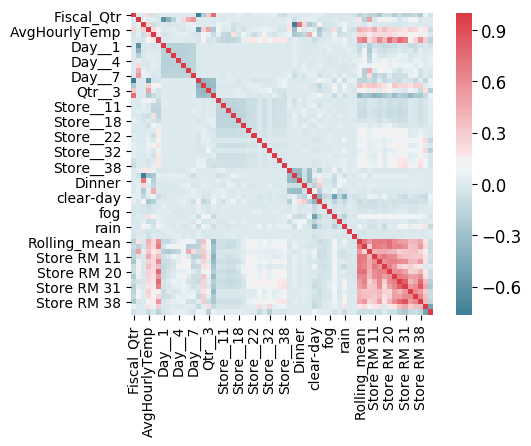

In [173]:
f, ax = plt.subplots(dpi=100)
plt.rc('font',size = 12)
corr = np_scaled.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [174]:
display((corr['SalesRevenue'].sort_values()).tail(11))
display((corr['SalesRevenue'].sort_values()).head(10))


Store__17        0.202817
Store RM 21      0.208009
Store RM 2       0.229813
AvgHourlyTemp    0.229903
Store RM 18      0.230360
Store RM 20      0.234312
Store RM 11      0.239688
Rolling_mean     0.246261
Store RM 17      0.251653
Lunch            0.442687
SalesRevenue     1.000000
Name: SalesRevenue, dtype: float64

Breakfast             -0.235527
Dinner                -0.197260
clear-night           -0.195934
Store__16             -0.152389
Late Night            -0.134431
Store__11             -0.129006
Qtr__4                -0.112826
Store__22             -0.082117
Hour                  -0.077105
partly-cloudy-night   -0.070913
Name: SalesRevenue, dtype: float64

In [175]:
gbr_feats = TreeFeatureEvaluation(model=GBR)

('AvgHourlyTemp', 0.22920505624373885)
('Hour', 0.20899078534731066)
('Timestamp', 0.12785057090943336)
('Lunch', 0.06377332185165295)
('Store RM 32', 0.055147275456872674)
('clear-night', 0.031702971138924965)
('Rolling_mean', 0.02182869399073455)
('Store RM 2', 0.02169950281036391)
('Store RM 21', 0.019376995559223731)
('Afternoon', 0.019359601230171122)
('Store RM 31', 0.018927687352376064)
('Store RM 18', 0.018414064203992272)
('Store RM 34', 0.018206927332359523)
('partly-cloudy-night', 0.016223932147115917)
('Day__6', 0.015382611298451808)
('Late Night', 0.013879914170529023)
('Store RM 17', 0.013440430114425101)
('Fiscal_dayofWk', 0.011833292703545268)
('Store RM 20', 0.011157528970770532)
('Store RM 16', 0.0093249902346955946)
('Store RM 36', 0.0078845350303615187)
('Store RM 22', 0.0075500672082057492)
('partly-cloudy-day', 0.0071918430050450068)
('Store RM 11', 0.0067205927519701)
('Breakfast', 0.0061992370938331312)
('rain', 0.0055635441785086273)
('Fiscal_Qtr', 0.0032563368

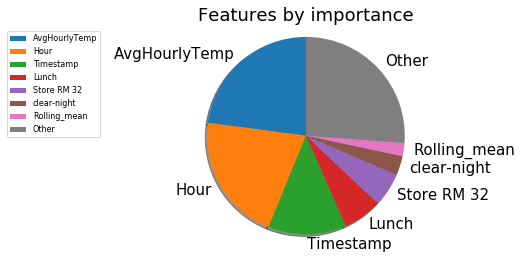

In [176]:
TreeFeatureChart(gbr_feats)

In [177]:
lagged_df.groupby('Daypart')['SalesRevenue'].describe()

,count,mean,std,min,25%,50%,75%,max
Daypart,,,,,,,,
Afternoon,28057.0,128.554550,70.518656,0.0,79.72,117.050,164.2100,998.97
Breakfast,32482.0,80.933205,71.400701,0.0,34.24,64.995,107.9275,1097.50
Dinner,34474.0,88.265783,51.831521,0.0,50.78,81.100,118.2000,887.38
Late Night,2178.0,23.311272,40.029577,0.0,4.49,11.210,32.1275,1023.24
Lunch,28106.0,195.815000,125.043355,0.0,110.51,168.960,247.2675,1101.78


In [178]:
lagged_df.groupby('Fiscal_Qtr')['SalesRevenue'].describe()

,count,mean,std,min,25%,50%,75%,max
Fiscal_Qtr,,,,,,,,
1,33260.0,111.916096,89.429688,0.0,51.7475,92.150,147.5525,1068.33
2,38027.0,132.619338,100.696226,0.0,67.0200,111.930,171.4200,1101.78
3,28604.0,125.664809,97.309378,0.0,63.7575,105.185,160.0500,1067.18
4,25406.0,97.338785,80.420436,0.0,45.6500,79.375,125.6200,1023.24


In [179]:
lagged_df.groupby('HourlyWeather')['SalesRevenue'].describe()

,count,mean,std,min,25%,50%,75%,max
HourlyWeather,,,,,,,,
clear-day,70494.0,124.698882,95.696426,0.00,62.600,102.985,159.320,1101.78
clear-night,12831.0,63.818536,56.409489,0.00,22.025,50.990,91.335,1023.24
cloudy,1571.0,96.854239,71.033064,0.00,44.265,84.020,133.200,645.16
fog,715.0,84.496350,65.234246,0.00,37.790,70.370,113.470,494.61
partly-cloudy-day,22403.0,144.222460,100.452489,0.00,78.530,123.390,183.725,1051.90
partly-cloudy-night,2225.0,68.773667,56.920499,0.00,26.380,55.950,97.620,516.05
rain,14563.0,107.715813,86.591211,0.00,53.870,89.400,137.370,1097.50
snow,55.0,54.893818,47.641024,4.04,21.700,44.030,72.440,262.89
wind,440.0,125.629659,92.701185,0.00,59.725,101.475,164.015,733.82
